<a href="https://colab.research.google.com/github/surendra-yarra/Momentum-Startegy-Portfolio/blob/main/Adaptive_Momentum_Startegy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plain Logic

/tmp/ipython-input-1985010753.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed


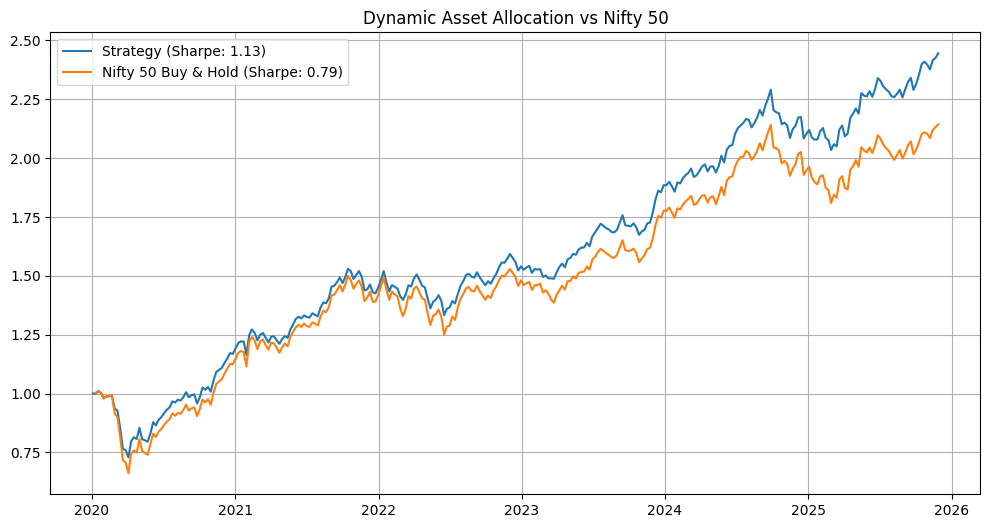

Strategy CAGR: 16.24% | Max DD: -27.84%
Nifty 50 CAGR: 13.69% | Max DD: -34.56%


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup and Data Download
tickers = {
    'index': '^NSEI',
    'equity': 'NIFTYBEES.NS',
    'debt': 'MOGSEC.NS',
    'gold': 'GOLDBEES.NS'
}

start_date = '2020-01-01' # Starting earlier to allow EMA warm-up
end_date = '2025-12-01'

data = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
data = data.ffill()

# 2. Signal Calculation
df = pd.DataFrame(data[tickers['index']]).rename(columns={tickers['index']: 'price'})
df['ema50'] = df['price'].ewm(span=50, adjust=False).mean()
df['ema100'] = df['price'].ewm(span=100, adjust=False).mean()
df['ema200'] = df['price'].ewm(span=200, adjust=False).mean()

# Resample to Weekly (Friday) for decision making
weekly = df.resample('W-FRI').last().copy()

# Logic for Consecutive Weeks
weekly['below_all'] = (weekly['price'] < weekly['ema50']) & \
                      (weekly['price'] < weekly['ema100']) & \
                      (weekly['price'] < weekly['ema200'])

weekly['above_50'] = (weekly['price'] > weekly['ema50'])

# 3. Define Allocation Rules
def get_allocation(row, prev_rows):
    price = row['price']
    e50, e100, e200 = row['ema50'], row['ema100'], row['ema200']

    # Check consecutive conditions from history
    cons_below_3 = prev_rows['below_all'].iloc[-3:].all() if len(prev_rows) >= 3 else False
    cons_above_2 = prev_rows['above_50'].iloc[-2:].all() if len(prev_rows) >= 2 else False

    # Scenario 2: Uptrend/Bullish Re-entry
    if cons_above_2:
        if price > (e50 * 1.05):
            return 90, 5, 5  # Extension rule
        return 95, 0, 5      # Strong trend

    # Scenario 1: Downtrend Logic
    if cons_below_3:
        return 80, 10, 10
    if price < e50 and price < e100 and price < e200:
        return 65, 15, 20
    if price < e50 and price < e100 and price > e200:
        return 75, 10, 15
    if price < e50 and price > e100:
        return 85, 10, 5

    # Default / Above all but not yet 2 weeks
    return 95, 0, 5

# Apply logic
allocations = []
for i in range(len(weekly)):
    alloc = get_allocation(weekly.iloc[i], weekly.iloc[:i+1])
    allocations.append(alloc)

weekly[['eq_w', 'db_w', 'gd_w']] = pd.DataFrame(allocations, index=weekly.index) / 100

# 4. Backtest Engine
# Align ETF prices with weekly signals
etf_prices = data[[tickers['equity'], tickers['debt'], tickers['gold']]].resample('W-FRI').last()
portfolio_returns = (etf_prices.pct_change() * weekly[['eq_w', 'db_w', 'gd_w']].shift(1).values).sum(axis=1)
cum_strategy = (1 + portfolio_returns).cumprod()
cum_nifty = (1 + weekly['price'].pct_change()).cumprod()

# 5. Performance Metrics
def get_metrics(returns):
    cagr = (returns.iloc[-1])**(1/(len(returns)/52)) - 1
    vol = returns.pct_change().std() * np.sqrt(52)
    sharpe = cagr / vol
    dd = (returns / returns.cummax() - 1).min()
    return cagr, vol, sharpe, dd

strat_m = get_metrics(cum_strategy.fillna(1))
nifty_m = get_metrics(cum_nifty.fillna(1))

# 6. Visualization
plt.figure(figsize=(12,6))
plt.plot(cum_strategy, label=f'Strategy (Sharpe: {strat_m[2]:.2f})')
plt.plot(cum_nifty, label=f'Nifty 50 Buy & Hold (Sharpe: {nifty_m[2]:.2f})')
plt.title('Dynamic Asset Allocation vs Nifty 50')
plt.legend()
plt.grid(True)
plt.show()

print(f"Strategy CAGR: {strat_m[0]*100:.2f}% | Max DD: {strat_m[3]*100:.2f}%")
print(f"Nifty 50 CAGR: {nifty_m[0]*100:.2f}% | Max DD: {nifty_m[3]*100:.2f}%")

# With Execution, Transaction costs, Slippages, Analytics

/tmp/ipython-input-2527042397.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(list(tickers.values()), start=START_DATE, end=END_DATE)['Close'].ffill().dropna()
[*********************100%***********************]  4 of 4 completed


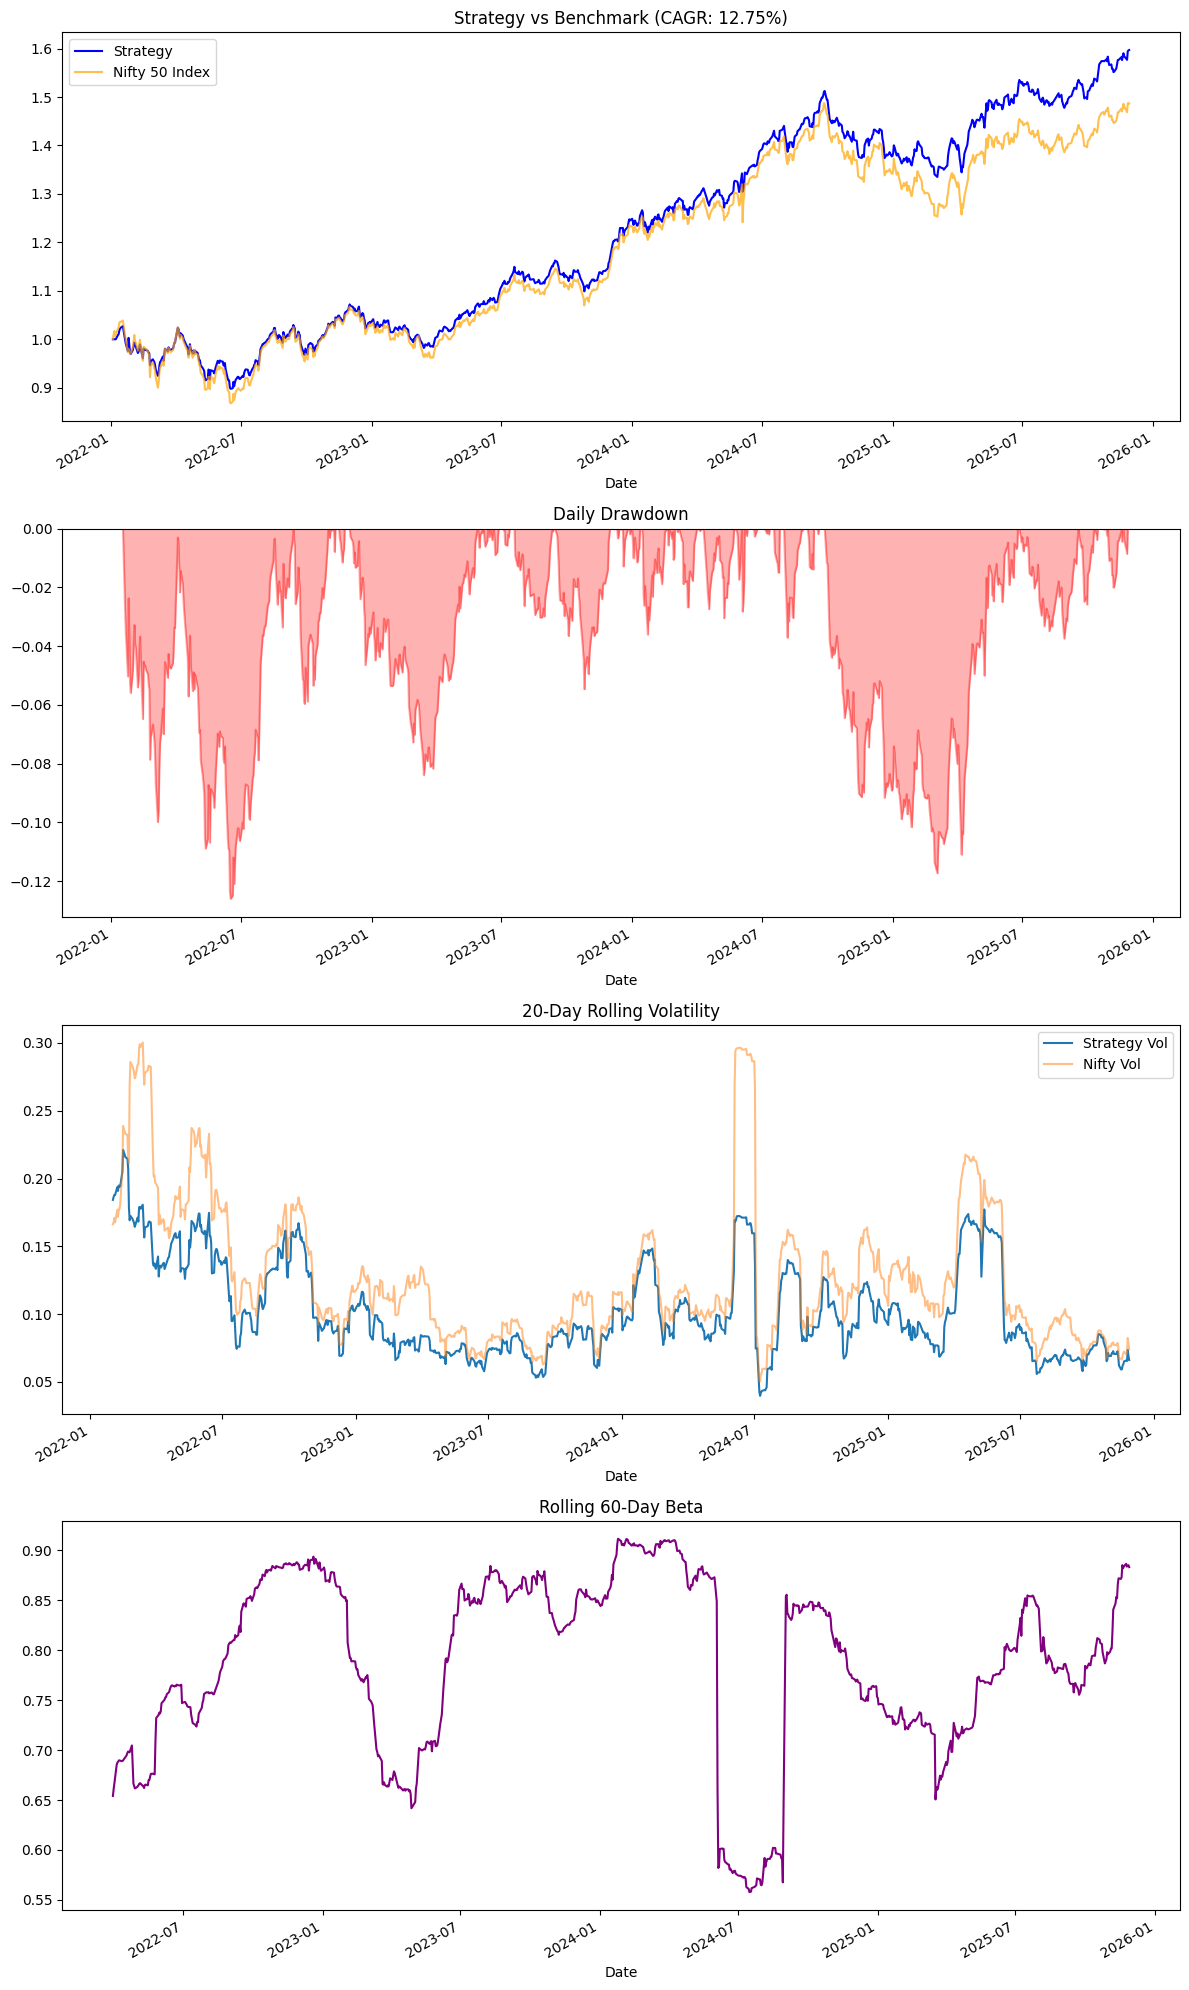

--- Performance Metrics ---
Strategy CAGR: 12.75% | Nifty CAGR: 10.70%
Sharpe Ratio: 0.62 | Max Drawdown: -12.60%


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Configuration & Data Fetching
INITIAL_INVESTMENT = 100000
CASH_BUFFER_PCT = 0.002
SLIPPAGE = 0.001
START_DATE = '2022-01-01'
END_DATE = '2025-12-01'

tickers = {
    'index': '^NSEI',
    'equity': 'NIFTYBEES.NS',
    'debt': 'MOGSEC.NS',
    'gold': 'GOLDBEES.NS'
}

# Fetch data and align dates strictly
all_data = yf.download(list(tickers.values()), start=START_DATE, end=END_DATE)['Close'].ffill().dropna()
index_data = all_data[tickers['index']]
etf_data = all_data[[tickers['equity'], tickers['debt'], tickers['gold']]]

# 2. Signal Generation (Daily)
signals = pd.DataFrame(index_data).rename(columns={tickers['index']: 'price'})
signals['ema50'] = signals['price'].ewm(span=50, adjust=False).mean()
signals['ema100'] = signals['price'].ewm(span=100, adjust=False).mean()
signals['ema200'] = signals['price'].ewm(span=200, adjust=False).mean()
signals['below_all'] = (signals['price'] < signals['ema50']) & (signals['price'] < signals['ema100']) & (signals['price'] < signals['ema200'])
signals['above_50'] = (signals['price'] > signals['ema50'])

def get_target_alloc(date, row, history):
    p, e50, e100, e200 = row['price'], row['ema50'], row['ema100'], row['ema200']
    hist_week = history.resample('W-FRI').last()

    # 2-week Above 50 EMA logic
    cons_above_2 = hist_week['above_50'].iloc[-2:].all() if len(hist_week) >= 2 else False
    if cons_above_2:
        return (0.90, 0.05, 0.05) if p > (e50 * 1.05) else (0.95, 0.00, 0.05)

    # 3-week Below All logic
    cons_below_3 = hist_week['below_all'].iloc[-3:].all() if len(hist_week) >= 3 else False
    if cons_below_3: return (0.80, 0.10, 0.10)

    # Scenarios with Gold/Debt Tilt
    if p < e50 and p < e100 and p < e200: return (0.65, 0.15, 0.20)
    if p < e50 and p < e100: return (0.75, 0.10, 0.15)
    if p < e50: return (0.85, 0.10, 0.05)

    return (0.95, 0.00, 0.05)

# 3. Iterative Backtest Engine
cash = INITIAL_INVESTMENT
holdings = {tickers['equity']: 0, tickers['debt']: 0, tickers['gold']: 0}
portfolio_log = []
transaction_log = []
last_alloc = None

for date, row in signals.iterrows():
    is_rebalance_day = (date.weekday() == 4)
    current_prices = etf_data.loc[date]
    holding_value = sum(holdings[t] * current_prices[t] for t in holdings)
    total_value = holding_value + cash

    rebal_triggered = "No"
    if is_rebalance_day:
        target_weights = get_target_alloc(date, row, signals.loc[:date])
        if target_weights != last_alloc:
            usable_val = total_value * (1 - CASH_BUFFER_PCT)

            # SELLS first
            for i, t in enumerate([tickers['equity'], tickers['debt'], tickers['gold']]):
                target_val = usable_val * target_weights[i]
                current_val = holdings[t] * current_prices[t]
                if current_val > target_val:
                    shares_to_sell = np.ceil((current_val - target_val) / current_prices[t])
                    sell_price = current_prices[t] * (1 - SLIPPAGE)
                    cash += (shares_to_sell * sell_price)
                    holdings[t] -= shares_to_sell
                    transaction_log.append({'Date': date, 'Security': t, 'Type': 'SELL', 'Price': sell_price, 'Shares': shares_to_sell})

            # BUYS second
            for i, t in enumerate([tickers['equity'], tickers['debt'], tickers['gold']]):
                target_val = usable_val * target_weights[i]
                current_val = holdings[t] * current_prices[t]
                if target_val > current_val:
                    buy_price = current_prices[t] * (1 + SLIPPAGE)
                    shares_to_buy = np.floor((target_val - current_val) / buy_price)
                    if cash >= (shares_to_buy * buy_price):
                        cash -= (shares_to_buy * buy_price)
                        holdings[t] += shares_to_buy
                        transaction_log.append({'Date': date, 'Security': t, 'Type': 'BUY', 'Price': buy_price, 'Shares': shares_to_buy})

            last_alloc = target_weights
            rebal_triggered = "Yes"

    portfolio_log.append({
        'Date': date, 'Holding_Value': holding_value, 'Cash': cash, 'Portfolio_Value': total_value,
        'Equity_W': (holdings[tickers['equity']]*current_prices[tickers['equity']])/total_value,
        'Debt_W': (holdings[tickers['debt']]*current_prices[tickers['debt']])/total_value,
        'Gold_W': (holdings[tickers['gold']]*current_prices[tickers['gold']])/total_value,
        'Rebalance': rebal_triggered, 'Absolute_Returns': (total_value/INITIAL_INVESTMENT)-1
    })

# 4. Analytics Calculation
port_df = pd.DataFrame(portfolio_log).set_index('Date')
port_df['Daily_Ret'] = port_df['Portfolio_Value'].pct_change()
bench_rets = index_data.pct_change()

# CAGR
years = (port_df.index[-1] - port_df.index[0]).days / 365.25
cagr = (port_df['Portfolio_Value'].iloc[-1] / INITIAL_INVESTMENT) ** (1/years) - 1
bench_cagr = (index_data.iloc[-1] / index_data.iloc[0]) ** (1/years) - 1

# Sharpe & Vol
std_dev = port_df['Daily_Ret'].std() * np.sqrt(252)
sharpe = (cagr - 0.06) / std_dev # Assuming 6% Risk Free Rate

# Beta
cov = port_df['Daily_Ret'].rolling(60).cov(bench_rets)
var = bench_rets.rolling(60).var()
port_df['Beta'] = cov / var

# 5. Output Files

with pd.ExcelWriter('Alpha_Strategy_Report.xlsx') as writer:
    pd.DataFrame(transaction_log).to_excel(writer, sheet_name='Transactions')
    port_df[['Equity_W', 'Debt_W', 'Gold_W']].to_excel(writer, sheet_name='Daily_Allocation')
    port_df[['Holding_Value', 'Cash', 'Portfolio_Value', 'Rebalance', 'Absolute_Returns', 'Beta']].to_excel(writer, sheet_name='Daily_Portfolio')

# 6. Plotting
fig, ax = plt.subplots(4, 1, figsize=(12, 20))

# Normalized Returns
(port_df['Portfolio_Value']/INITIAL_INVESTMENT).plot(ax=ax[0], label='Strategy', color='blue')
(index_data/index_data.iloc[0]).plot(ax=ax[0], label='Nifty 50 Index', color='orange', alpha=0.7)
ax[0].set_title(f'Strategy vs Benchmark (CAGR: {cagr*100:.2f}%)')
ax[0].legend()

# Drawdown
dd = port_df['Portfolio_Value'] / port_df['Portfolio_Value'].cummax() - 1
dd.plot(ax=ax[1], kind='area', color='red', alpha=0.3, title='Daily Drawdown')

# Volatility
port_df['Daily_Ret'].rolling(20).std().apply(lambda x: x*np.sqrt(252)).plot(ax=ax[2], label='Strategy Vol')
bench_rets.rolling(20).std().apply(lambda x: x*np.sqrt(252)).plot(ax=ax[2], label='Nifty Vol', alpha=0.5)
ax[2].set_title('20-Day Rolling Volatility')
ax[2].legend()

# Beta
port_df['Beta'].plot(ax=ax[3], title='Rolling 60-Day Beta', color='purple')
plt.tight_layout()
plt.show()

print(f"--- Performance Metrics ---")
print(f"Strategy CAGR: {cagr*100:.2f}% | Nifty CAGR: {bench_cagr*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f} | Max Drawdown: {dd.min()*100:.2f}%")


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
try:
    from google.colab import files
except ImportError:
    files = None

# 1. Configuration & Data Fetching
INITIAL_INVESTMENT = 100000
CASH_BUFFER_PCT = 0.002
SLIPPAGE = 0.001
START_DATE = '2021-01-01'
END_DATE = '2024-12-31'

tickers = {
    'index': '^NSEI',
    'equity': 'NIFTYBEES.NS',
    'debt': 'MOGSEC.NS',
    'gold': 'GOLDBEES.NS'
}

# Fetch data and align dates strictly
all_data = yf.download(list(tickers.values()), start=START_DATE, end=END_DATE)['Close'].ffill().dropna()
index_data = all_data[tickers['index']]
etf_data = all_data[[tickers['equity'], tickers['debt'], tickers['gold']]]

# 2. Signal Generation
signals = pd.DataFrame(index_data).rename(columns={tickers['index']: 'price'})
signals['ema50'] = signals['price'].ewm(span=50, adjust=False).mean()
signals['ema100'] = signals['price'].ewm(span=100, adjust=False).mean()
signals['ema200'] = signals['price'].ewm(span=200, adjust=False).mean()
signals['below_all'] = (signals['price'] < signals['ema50']) & (signals['price'] < signals['ema100']) & (signals['price'] < signals['ema200'])
signals['above_50'] = (signals['price'] > signals['ema50'])

def get_target_alloc(date, row, history):
    p, e50, e100, e200 = row['price'], row['ema50'], row['ema100'], row['ema200']
    hist_week = history.resample('W-FRI').last()

    cons_above_2 = hist_week['above_50'].iloc[-2:].all() if len(hist_week) >= 2 else False
    if cons_above_2:
        return (0.90, 0.05, 0.05) if p > (e50 * 1.05) else (0.95, 0.00, 0.05)

    cons_below_3 = hist_week['below_all'].iloc[-3:].all() if len(hist_week) >= 3 else False
    if cons_below_3: return (0.80, 0.10, 0.10)

    if p < e50 and p < e100 and p < e200: return (0.65, 0.15, 0.20)
    if p < e50 and p < e100: return (0.75, 0.10, 0.15)
    if p < e50: return (0.85, 0.10, 0.05)

    return (0.95, 0.00, 0.05)

# 3. Iterative Backtest Engine
cash = INITIAL_INVESTMENT
holdings = {tickers['equity']: 0, tickers['debt']: 0, tickers['gold']: 0}
portfolio_log = []
transaction_log = []
last_alloc = None

for date, row in signals.iterrows():
    is_rebalance_day = (date.weekday() == 4)
    current_prices = etf_data.loc[date]
    holding_value = sum(holdings[t] * current_prices[t] for t in holdings)
    total_value = holding_value + cash

    rebal_triggered = "No"
    if is_rebalance_day:
        target_weights = get_target_alloc(date, row, signals.loc[:date])
        if target_weights != last_alloc:
            usable_val = total_value * (1 - CASH_BUFFER_PCT)

            # SELLS (Round Up)
            for i, t in enumerate([tickers['equity'], tickers['debt'], tickers['gold']]):
                target_val = usable_val * target_weights[i]
                current_val = holdings[t] * current_prices[t]
                if current_val > target_val:
                    shares_to_sell = np.ceil((current_val - target_val) / current_prices[t])
                    sell_price = current_prices[t] * (1 - SLIPPAGE)
                    cash += (shares_to_sell * sell_price)
                    holdings[t] -= shares_to_sell
                    transaction_log.append({'Date': date, 'Security': t, 'Type': 'SELL', 'Price': sell_price, 'Shares': shares_to_sell})

            # BUYS (Round Down)
            for i, t in enumerate([tickers['equity'], tickers['debt'], tickers['gold']]):
                target_val = usable_val * target_weights[i]
                current_val = holdings[t] * current_prices[t]
                if target_val > current_val:
                    buy_price = current_prices[t] * (1 + SLIPPAGE)
                    shares_to_buy = np.floor((target_val - current_val) / buy_price)
                    if cash >= (shares_to_buy * buy_price):
                        cash -= (shares_to_buy * buy_price)
                        holdings[t] += shares_to_buy
                        transaction_log.append({'Date': date, 'Security': t, 'Type': 'BUY', 'Price': buy_price, 'Shares': shares_to_buy})

            last_alloc = target_weights
            rebal_triggered = "Yes"

    portfolio_log.append({
        'Date': date, 'Holding_Value': holding_value, 'Cash': cash, 'Portfolio_Value': total_value,
        'Equity_Allocation': (holdings[tickers['equity']]*current_prices[tickers['equity']])/total_value,
        'Debt_Allocation': (holdings[tickers['debt']]*current_prices[tickers['debt']])/total_value,
        'Commodity_Allocation': (holdings[tickers['gold']]*current_prices[tickers['gold']])/total_value,
        'Rebalance_Triggered': rebal_triggered, 'Absolute_Returns': (total_value/INITIAL_INVESTMENT)-1
    })

# 4. Final Calculations & Excel Export
port_df = pd.DataFrame(portfolio_log).set_index('Date')
port_df['Daily_Ret'] = port_df['Portfolio_Value'].pct_change()
bench_rets = index_data.pct_change()

# Metrics
years = (port_df.index[-1] - port_df.index[0]).days / 365.25
cagr = (port_df['Portfolio_Value'].iloc[-1] / INITIAL_INVESTMENT) ** (1/years) - 1
vol = port_df['Daily_Ret'].std() * np.sqrt(252)
sharpe = (cagr - 0.06) / vol
cov = port_df['Daily_Ret'].rolling(60).cov(bench_rets)
var = bench_rets.rolling(60).var()
port_df['Beta'] = cov / var

# Generate File
filename = 'Adaptive_Alpha_Report.xlsx'
with pd.ExcelWriter(filename) as writer:
    pd.DataFrame(transaction_log).to_excel(writer, sheet_name='Transaction_History', index=False)
    port_df[['Equity_Allocation', 'Debt_Allocation', 'Commodity_Allocation']].to_excel(writer, sheet_name='Daily_Alloc_Bifurcation')
    port_df[['Holding_Value', 'Cash', 'Portfolio_Value', 'Rebalance_Triggered', 'Absolute_Returns', 'Beta']].to_excel(writer, sheet_name='Daily_Portfolio_Report')

print(f"Report Generated: {filename}")
if files:
    files.download(filename)

/tmp/ipython-input-3411267454.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(list(tickers.values()), start=START_DATE, end=END_DATE)['Close'].ffill().dropna()
[*********************100%***********************]  4 of 4 completed


Report Generated: Adaptive_Alpha_Report.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>